PyTorch implementation of the paper: 


M. Afifi, A. Abuolaim, M. Korashy,  M. A. Brubaker, and M. S. Brown. Color-Aware Style Transfer. arXiv preprint 2021.

# Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import copy
import cv2
import math
from torchvision.utils import save_image
import os
import scipy.io

# Settings

Input images

In [ ]:
STYLE_IMAGE = "./style.jpg"
CONTENT_IMAGE = "./content.jpg"

Settings

In [ ]:
SMOOTH = True
SHOW_MASKS = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SELECT_MATCHES = False # set to True to select color correspondences in palettes
EPS = 1e-6
SIGMA = 0.25 # 0.25 and 0.3 work well in most cases
PALETTE_SIZE = 5
ADD_BLACK_WHITE = False
STYLE_LOSS_WEIGHT = 10000
CONTENT_LOSS_WEIGHT = 1
COLOR_DISTANCE = 'chroma_L2'  # Options: 'chroma_L2', 'L2'
STYLE_FEATURE_DISTANCE = 'L2'  # Options: 'L2', 'COSINE'
CONTENT_FEATURE_DISTANCE = 'L2'  # Options: 'L2', 'COSINE'
OPTIMIZER = 'LBFGS'  # Options: 'LBFGS', 'Adam', 'Adagrad'
LR = 0.5
ITERATIONS = 300
IMAGE_SIZE = 384
# desired size of the output image
imsize = IMAGE_SIZE if torch.cuda.is_available() else 128
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4', 'conv_5']
color_aware_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Color palette 
Ref: https://github.com/tody411/PaletteSelection

Helper functions

In [ ]:
## Convert image into float32 type.
def to32F(img):
    if img.dtype == np.float32:
        return img
    return (1.0 / 255.0) * np.float32(img)

## RGB channels of the image.
def rgb(img):

    if len(img.shape) == 2:
        h, w = img.shape
        img_rgb = np.zeros((h, w, 3), dtype=img.dtype)
        for ci in range(3):
            img_rgb[:, :, ci] = img
        return img_rgb

    h, w, cs = img.shape
    if cs == 3:
        return img

    img_rgb = np.zeros((h, w, 3), dtype=img.dtype)

    cs = min(3, cs)

    for ci in range(cs):
        img_rgb[:, :, ci] = img[:, :, ci]
    return img_rgb

## RGB to Lab.
def rgb2Lab(img):
    img_rgb = rgb(img)
    Lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    return Lab


## Lab to RGB.
def Lab2rgb(img):
    rgb = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return rgb


def _isGray(image):
    return len(image.shape) == 2


## True if x is a vector.
def isVector(x):
    return x.size == x.shape[0]


## True if x is a matrix.
def isMatrix(x):
    return not isVector(x)


## Norm of vectors (n x m matrix).
def normVectors(x):
    return np.sqrt(l2NormVectors(x))


## L2 norm of vectors (n x m matrix).
#  n x 1 vector: call np.square.
#  n x m vectors: call np.einsum.
def l2NormVectors(x):
    if isVector(x):
        return np.square(x)
    else:
        return np.einsum('...i,...i', x, x)

def colorCoordinates(color_ids, num_bins, color_range):
    color_ids = np.array(color_ids).T
    c_min, c_max = color_range
    color_coordinates = c_min + (
        color_ids * (c_max - c_min)) / float(num_bins - 1.0)
    return color_coordinates


def colorDensities(hist_bins):
    hist_positive = hist_bins > 0.0
    color_densities = np.float32(hist_bins[hist_positive])

    density_max = np.max(color_densities)
    color_densities = color_densities / density_max

    return color_densities


def rgbColors(hist_bins, color_bins):
    hist_positive = hist_bins > 0.0

    colors = color_bins[hist_positive, :]
    colors = np.clip(colors, 0.0, 1.0)
    return colors


def clipLowDensity(hist_bins, color_bins, alpha):
    density_mean = np.mean(hist_bins)
    low_density = hist_bins < density_mean * alpha
    hist_bins[low_density] = 0.0

    for ci in range(3):
        color_bins[low_density, ci] = 0.0


def densitySizes(color_densities, density_size_range):
    density_size_min, density_size_max = density_size_range
    density_size_factor = density_size_max / density_size_min
    density_sizes = density_size_min * np.power(
        density_size_factor, color_densities)
    return density_sizes


def range2ticks(tick_range, decimals=1):
    ticks = np.around(tick_range, decimals=decimals)
    ticks[ticks > 10] = np.rint(ticks[ticks > 10])
    return ticks


def range2lims(tick_range):
    unit = 0.1 * (tick_range[:, 1] - tick_range[:, 0])
    lim = np.array(tick_range)
    lim[:, 0] += -unit
    lim[:, 1] += unit

    return lim


Color pixels class

In [ ]:
#  input image is automatically converted into np.float32 format.
class ColorPixels:

    def __init__(self, image, num_pixels=1000):
        self._image = to32F(image)
        self._num_pixels = num_pixels
        self._rgb_pixels = None
        self._Lab = None
        self._hsv = None

    ## RGB pixels.
    def rgb(self):
        if self._rgb_pixels is None:
            self._rgb_pixels = self.pixels("rgb")
        return self._rgb_pixels

    ## Lab pixels.
    def Lab(self):
        if self._Lab is None:
            self._Lab = self.pixels("Lab")
        return self._Lab

    ## Pixels of the given color space.
    def pixels(self, color_space="rgb"):
        image = np.array(self._image)

        if color_space == "Lab":
            image = rgb2Lab(self._image)

        return self._image2pixels(image)

    def _image2pixels(self, image):
        if _isGray(image):
            h, w = image.shape
            step = int(h * w / self._num_pixels)
            return image.reshape((h * w))[::step]

        h, w, cs = image.shape
        step = int(h * w / self._num_pixels)
        return image.reshape((-1, cs))[::step]

3D color histograms

In [ ]:
## Implementation of 3D color histograms.
class Hist3D:
    def __init__(self, image,
                 num_bins=16, alpha=0.1, color_space='rgb'):
        self._computeTargetPixels(image, color_space)
        self._num_bins = num_bins
        self._alpha = alpha
        self._color_space = color_space
        self._computeColorRange()
        self._computeHistogram()

    def colorSpace(self):
        return self._color_space

    def colorIDs(self):
        color_ids = np.where(self._histPositive())
        return color_ids

    def colorCoordinates(self):
        color_ids = self.colorIDs()
        num_bins = self._num_bins
        color_range = self._color_range
        return colorCoordinates(color_ids, num_bins, color_range)

    def colorDensities(self):
        return colorDensities(self._hist_bins)

    def rgbColors(self):
        return rgbColors(self._hist_bins, self._color_bins)

    def colorRange(self):
        return self._color_range

    def _computeTargetPixels(self, image, color_space):
        color_pixels = ColorPixels(image)
        self._pixels = color_pixels.pixels(color_space)
        self._rgb_pixels = color_pixels.rgb()

    def _computeColorRange(self):
        pixels = self._pixels
        cs = pixels.shape[1]

        c_min = np.zeros(cs)
        c_max = np.zeros(cs)
        for ci in range(cs):
            c_min[ci] = np.min(pixels[:, ci])
            c_max[ci] = np.max(pixels[:, ci])

        self._color_range = [c_min, c_max]

    def _computeHistogram(self):
        pixels = self._pixels
        num_bins = self._num_bins
        c_min, c_max = self._color_range

        hist_bins = np.zeros((num_bins, num_bins, num_bins), dtype=np.float32)
        color_bins = np.zeros((num_bins, num_bins, num_bins, 3), 
                              dtype=np.float32)

        color_ids = (num_bins - 1) * (pixels - c_min) / (c_max - c_min)
        color_ids = np.int32(color_ids)

        for pi, color_id in enumerate(color_ids):
            hist_bins[color_id[0], color_id[1], color_id[2]] += 1
            color_bins[color_id[0], color_id[1], 
                       color_id[2]] += self._rgb_pixels[pi]

        self._hist_bins = hist_bins
        hist_positive = self._hist_bins > 0.0

        for ci in range(3):
            color_bins[hist_positive, ci] /= self._hist_bins[hist_positive]

        self._color_bins = color_bins

        self._clipLowDensity()

    def _clipLowDensity(self):
        clipLowDensity(self._hist_bins, self._color_bins, self._alpha)

    def _histPositive(self):
        return self._hist_bins > 0.0

Auto palette selection

In [ ]:

## Implementation of automatic palette selection.
class PaletteSelection:
    def __init__(self, color_coordinates, color_densities, rgb_colors,
                 num_colors=7, sigma=70.0):
        self._color_coordinates = color_coordinates
        self._color_densities = color_densities
        self._rgb_colors = rgb_colors
        self._num_colors = num_colors
        self._sigma = sigma
        self._palette_coordinates = []
        self._palette_colors = []
        self._computeDarkBrightColors()
        self._computeInitialWeight()
        self._compute()

    def paletteCoordinates(self):
        return self._palette_coordinates

    def paletteColors(self):
        return self._palette_colors

    def _compute(self):
        for i in range(self._num_colors):
            palette_coordinate = self._updatePalette()
            self._updateWeight(palette_coordinate)

    def _computeDarkBrightColors(self):
        rgb_colors = self._rgb_colors

        intensities = normVectors(rgb_colors)
        c_dark = self._color_coordinates[np.argmin(intensities)]
        c_bright = self._color_coordinates[np.argmax(intensities)]
        self._dark_bright = [c_dark, c_bright]

    def _computeInitialWeight(self):
        self._color_weights = np.array(self._color_densities)
        self._updateWeight(self._dark_bright[0])
        self._updateWeight(self._dark_bright[1])

    def _updatePalette(self):
        color_id = np.argmax(self._color_weights)
        palette_coordinate = self._color_coordinates[color_id]
        self._palette_coordinates.append(palette_coordinate)

        palette_color = self._rgb_colors[color_id]
        self._palette_colors.append(palette_color)
        return palette_coordinate

    def _updateWeight(self, palette_coordinate):
        dists = normVectors(self._color_coordinates - palette_coordinate)
        factors = 1.0 - np.exp(- dists ** 2 / (self._sigma ** 2))
        self._color_weights = factors * self._color_weights


Mask generation

In [ ]:
class CreateMask(nn.Module):
  def __init__(self, insz=imsize, color_palette=None, sigma=SIGMA,
               smooth=SMOOTH, distance=COLOR_DISTANCE):
    """ Computes masks of the image based on a given color palette
    Args:
      insz: maximum size of the input image; if it is larger than this size, the 
        image will be resized (scalar). Default value is imsize (i.e., 
        imsize x imsize pixels).
      color_palette: kx3 tensor of color palette
      sigma: this is the sigma parameter of the kernel function. 
        The default value is 0.02.
      smooth: boolean flag to apply a Gaussian blur after creating the mask.
      distance: it can be one of the following options: 'chroma_L2' or 'L2'

    Methods:
      forward: accepts input image and returns its masks based on the input 
      color palette
    """
    super(CreateMask, self).__init__()
    self.color_palette = color_palette
    self.insz = insz
    self.device = DEVICE
    self.sigma = sigma
    self.distance=distance
    self.smooth = smooth
    

  def forward(self, x):
    if self.color_palette is None:
      raise NameError('No color palette is given')
    x = torch.clamp(x, 0, 1)
    I = F.interpolate(x, size=(self.insz, self.insz),
                              mode='bilinear', align_corners=False)
    masks = torch.zeros(1, self.color_palette.shape[0], self.insz, self.insz, 
                        device=DEVICE)
    if I.shape[1] > 3:
      I = I[:, :3, :, :]
    if self.distance == 'chroma_L2':
        I = I / (torch.unsqueeze(torch.sum(I, dim=1), dim=1) + EPS)

    for c in range(self.color_palette.shape[0]):
      color = self.color_palette[c, :].view(1, 3, 1, 1)
      if self.distance == 'chroma_L2':
          color = color / (torch.unsqueeze(torch.sum(color, dim=1), dim=1) +
                           EPS)
      dist = torch.sqrt(torch.sum((I - color) ** 2, dim=1))
      weight = torch.exp(-1 * (dist / self.sigma) ** 2)
      if self.smooth:
          weight = nn.functional.conv2d(torch.unsqueeze(weight, dim=0),
                                        gaussian_kernel,
                                        bias=None, stride=1, padding=7)
      masks[0, c, :, :] = weight
    return masks

# Loss Functions

Gram matrix

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size() 
    features = input.view(a * b, c * d)  
    G = torch.mm(features, features.t())  # compute the gram product
    return G.div(a * b * c * d)

Masked Gram matrix

In [ ]:
def masked_gram_matrix(input, masks):
    k = masks.shape[1]
    a, b, c, d = input.size()
    masks = F.interpolate(masks, size=(c, d), mode='bilinear', 
                          align_corners=False)
    G = torch.zeros(k, a * b * a * b, device=DEVICE)
    features = input.view(a * b, c * d)
    for i in range(k):
      mask_values = masks[:, i, :, :].view(a, c * d)
      mask_values = (mask_values - torch.min(mask_values)) / (
          torch.max(mask_values) - torch.min(mask_values))
      #num_elements = torch.sum(mask_values > 0.05)
      num_elements = torch.sum(mask_values)
      #compute the gram product
      weighted_features = features * mask_values
      g = torch.mm(weighted_features, weighted_features.t())  
      #g = torch.mm(weighted_features[:, 1:], weighted_features[:, :-1].t())
      #G[i, :] = g.div(a * b * c * d).view(1, a * b * a * b)
      G[i, :] = g.div(num_elements).view(1, a * b * a * b)
    return G / k


Content loss

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        if CONTENT_FEATURE_DISTANCE == 'L2':
            self.loss = F.mse_loss(input, self.target)
        elif CONTENT_FEATURE_DISTANCE == 'COSINE':
            self.loss = cosine_similarity(input, self.target)
        else:
            raise NotImplementedError

        return input

Cosine similarity

In [ ]:
def cosine_similarity(x, y):
    x = x.view(1, -1)
    y = y.view(1, -1)
    return 1 - (torch.sum(x * y)/(x.norm(2) * y.norm(2) + EPS))

def set_requires_grad(model, bool):
    for p in model.parameters():
        p.requires_grad = bool


Color-aware loss

In [ ]:
class ColorAwareLoss(nn.Module):
    def __init__(self, target_feature, target_masks):
        super(ColorAwareLoss, self).__init__()
        self.target = masked_gram_matrix(target_feature, target_masks).detach()
        self.input_masks = target_masks
    
    def set_input_masks(self, input_masks):
        self.input_masks = input_masks

    def forward(self, input):
        G = masked_gram_matrix(input, self.input_masks)
        if STYLE_FEATURE_DISTANCE == 'L2':
            self.loss = F.mse_loss(G, self.target)
        elif STYLE_FEATURE_DISTANCE == 'COSINE':
            self.loss = cosine_similarity(G, self.target)
        else:
            raise NotImplementedError

        return input

# Image loader and visualization

Image loader

In [ ]:
def image_loader(image_name, K=16):
    image = Image.open(image_name)
    # compute color palette
    img_array = np.array(image)
    # 16 bins, Lab color space
    hist3D = Hist3D(img_array, num_bins=16, color_space='Lab')

    color_coordinates = hist3D.colorCoordinates()
    color_densities = hist3D.colorDensities()
    rgb_colors = hist3D.rgbColors()

    palette_selection = PaletteSelection(color_coordinates, color_densities, 
                                         rgb_colors, num_colors=K, sigma=70.0)
    colors = palette_selection._palette_colors

    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(DEVICE, torch.float), torch.tensor(
        colors).to(DEVICE, torch.float)

Visualization

In [ ]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

# Other classes and functions

Normalization


In [ ]:
# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

Get optimizer

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    if OPTIMIZER == 'LBFGS':
        optimizer = optim.LBFGS([input_img.requires_grad_()], lr=LR)
    elif OPTIMIZER == 'Adam':
        optimizer = optim.Adam([input_img.requires_grad_()], lr=LR)
    elif OPTIMIZER == 'Adagrad':
        optimizer = optim.Adagrad([input_img.requires_grad_()], lr=LR)
    else:
        raise NotImplementedError


    return optimizer

Get style model and losses

In [ ]:

def get_style_model_and_losses(cnn, normalization_mean, 
                               normalization_std,
                               style_img, content_img, 
                               style_img_masks, 
                               content_layers=content_layers_default,
                               #style_layers=style_layers_default, 
                               color_aware_layers=color_aware_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, 
                                  normalization_std).to(DEVICE)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []
    color_aware_style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(
                layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in color_aware_layers_default:
            # add style loss:
            target_feature = model(style_img).detach()
            color_aware_loss = ColorAwareLoss(target_feature, style_img_masks)
            model.add_module("color_aware_loss_{}".format(i), color_aware_loss)
            color_aware_style_losses.append(color_aware_loss)

    for i in range(len(model) - 1, -1, -1):
        if (isinstance(model[i], ContentLoss) or 
            isinstance(model[i], ColorAwareLoss)):
            break
    model = model[:(i + 1)]

    return model, content_losses, color_aware_style_losses


If SMOOTH is true, create a Gaussian blur kernel.

In [ ]:
if SMOOTH:
    """# Gaussian blur kernel"""

    # Set these to whatever you want for your gaussian filter
    kernel_size = 15
    sigma = 5

    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_cord = torch.arange(kernel_size)
    x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1)

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance))
    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.to(device=DEVICE)

# Run style transfer

Main function to run style transfer

In [ ]:

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, style_img_masks,
                       num_steps=ITERATIONS, update_masks=True,
                       color_aware_weight=STYLE_LOSS_WEIGHT,
                       content_weight=CONTENT_LOSS_WEIGHT):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, content_losses, color_aware_losses = ( 
    get_style_model_and_losses(cnn, normalization_mean, normalization_std, 
                               style_img, content_img, style_img_masks))
   
    optimizer = get_input_optimizer(input_img)

    mask_generator = CreateMask(color_palette=final_palette)

    if not update_masks:
      input_masks = mask_generator(input_img).detach()
      for i in range(len(model) - 1, -1, -1):
                if isinstance(model[i], ColorAwareLoss):
                  model[i].set_input_masks(input_masks)
                  
    print('Optimizing..')
    run = [0]

    while run[0] <= num_steps:
        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()

            if update_masks:
              input_masks = mask_generator(input_img).detach()

            
            if SHOW_MASKS and run[0] % 50 == 0:
              for i in range(final_palette.shape[0]):
                plt.figure()
                imshow(style_masks[:, i, :, :], 
                       title=f'Style Mask of Color # {i}')
                plt.figure()
                imshow(input_masks[:, i, :, :], 
                       title=f'Input Mask of Color # {i}')

            if update_masks:
              for i in range(len(model) - 1, -1, -1):
                if isinstance(model[i], ColorAwareLoss):
                  model[i].set_input_masks(input_masks)


            model(input_img)

            content_score = 0
            color_aware_score = 0
           
            for cl in content_losses:
                content_score += cl.loss
            for cal in color_aware_losses:
                color_aware_score += cal.loss

            content_score *= content_weight
            color_aware_score *= color_aware_weight
            
            loss = content_score + color_aware_score 

            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))              
                print('Content Loss: {:4f} Color-Aware Loss: {:4f}'.format(
                    content_score.item(), color_aware_score.item()))
            
            return content_score + color_aware_score 
            

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img


Main steps

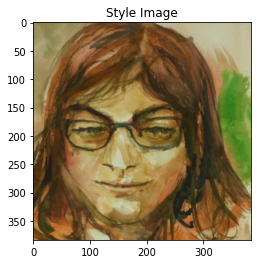

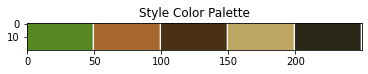

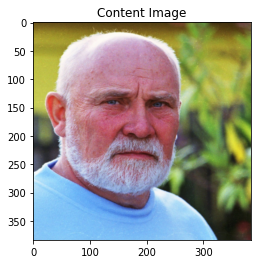

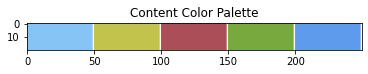

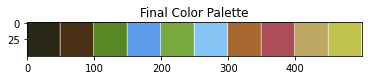

Building the style transfer model..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Optimizing..
run [50]:
Content Loss: 27.188820 Color-Aware Loss: 95.521988
run [100]:
Content Loss: 26.485903 Color-Aware Loss: 34.819805
run [150]:
Content Loss: 24.540947 Color-Aware Loss: 23.024391
run [200]:
Content Loss: 22.929131 Color-Aware Loss: 17.351818
run [250]:
Content Loss: 21.951126 Color-Aware Loss: 15.080429
run [300]:
Content Loss: 21.231529 Color-Aware Loss: 12.791881


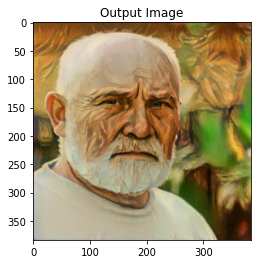

In [ ]:

"""# Image Loader"""

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

unloader = transforms.ToPILImage()  # reconvert into PIL image

style_img, style_palette = image_loader(STYLE_IMAGE, PALETTE_SIZE)

content_img, content_palette = image_loader(CONTENT_IMAGE, PALETTE_SIZE)


assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"


""" Image visualization"""

plt.ion()

style_img_color_palette_vis = torch.ones((1, 3, 20, 50 * PALETTE_SIZE),
                                         device=DEVICE)
content_img_color_palette_vis = torch.ones((1, 3, 20,50 * PALETTE_SIZE),
                                           device=DEVICE)


for c in range(PALETTE_SIZE):
    style_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (
        style_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *
        style_palette[c, :].view(1, 3, 1, 1))
    content_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (
        content_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *
        content_palette[c, :].view(1, 3, 1, 1))
  

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(style_img_color_palette_vis, title='Style Color Palette')

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(content_img_color_palette_vis, title='Content Color Palette')

""" Mask generation"""

if SELECT_MATCHES:
  print('Please enter color matching order. ', 
  'For example to link the first color of content palette to the third color',
  ' in style palette, please enter: 0, 2\n This will be repeated until you ',
  'enter -1.')
  user_input = input()
  matching_order_content = []
  matching_order_style = []
  while user_input != '-1':
    parts = str.split(user_input, ',')
    c = int(parts[0])
    s = int(parts[1])
    assert style_palette.shape[0] > s and content_palette.shape[0] > c
    matching_order_content.append(c)
    matching_order_style.append(s)
    user_input = input()
  sorted_style_order = np.sort(matching_order_style)
  style_palette = style_palette[sorted_style_order, :]
  sorting_inds = list(np.argsort(matching_order_style).astype(int))
  sorted_content_order = [matching_order_content[i] for i in sorting_inds]
  content_palette = content_palette[sorted_content_order, :]
  PALETTE_SIZE = len(sorted_content_order)
  style_img_color_palette_vis = torch.ones((1, 3, 20, 50 * PALETTE_SIZE),
                                         device=DEVICE)
  content_img_color_palette_vis = torch.ones((1, 3, 20,50 * PALETTE_SIZE),
                                           device=DEVICE)

  for c in range(PALETTE_SIZE):
    style_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (
        style_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *
        style_palette[c, :].view(1, 3, 1, 1))
    content_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (
        content_img_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *
        content_palette[c, :].view(1, 3, 1, 1))
    
  plt.figure()
  imshow(style_img_color_palette_vis, title='Final Style Color Palette')

  plt.figure()
  imshow(content_img_color_palette_vis, title='Matched Content Color Palette')

  final_palette = content_palette.clone()
  mask_generator_style = CreateMask(color_palette=style_palette)
  mask_generator_content = CreateMask(color_palette=content_palette)

else:
  final_palette = torch.cat([style_palette, content_palette], dim=0)
  if ADD_BLACK_WHITE:
    black_white = torch.tensor([[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]],
                           dtype=torch.float32, device=DEVICE)
    final_palette = torch.cat([final_palette, black_white], dim=0)

  final_palette = torch.unique(final_palette, dim=0)
  final_color_palette_vis = torch.ones((1, 3, 50, 50 * final_palette.shape[0]), 
                                     device=DEVICE)
  for c in range(final_palette.shape[0]):
    final_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] = (
        final_color_palette_vis[0, :, :, c * 50 : (c + 1) * 50 - 1] *
        final_palette[c, :].view(1, 3, 1, 1))
  plt.figure()
  imshow(final_color_palette_vis, title='Final Color Palette')
  mask_generator_style = CreateMask(color_palette=final_palette)
  mask_generator_content = CreateMask(color_palette=final_palette)


style_masks = mask_generator_style(style_img)

content_masks = mask_generator_content(content_img)

if SHOW_MASKS:
    for i in range(final_palette.shape[0]):
        plt.figure()
        imshow(style_masks[:, i, :, :], title=f'Style Mask of Color # {i}')
        plt.figure()
        imshow(content_masks[:, i, :, :], title=f'Content Mask of Color # {i}')
        

""" Loading VGG model"""

cnn = models.vgg19(pretrained=True).features.to(DEVICE).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)


input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=DEVICE)

""" Run style transfer"""

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, style_img, style_masks, 
                            update_masks=not SELECT_MATCHES)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()


save_image(output.squeeze(0), 'output.png')